### Forced Alignment with Wav2Vec2

In this notebook we are going to follow [this pytorch tutorial](https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html) to align script to speech with torchaudio using the CTC segmentation algorithm described in [ CTC-Segmentation of Large Corpora for German End-to-end Speech Recognition](https://arxiv.org/abs/2007.09127)


The process of alignment looks like the following.

1. Estimate the frame-wise label probability from audio waveform
Generate the trellis matrix which represents the probability of labels aligned at time step.
2. Find the most likely path from the trellis matrix.
3. In this example, we use torchaudio’s Wav2Vec2 model for acoustic feature extraction.


### Installation of `tourchaudio`

In [1]:
!pip install torchaudio

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x5625b25b6000 @  0x7f581be12615 0x5625790604cc 0x56257914047a 0x5625790632ed 0x562579154e1d 0x5625790d6e99 0x5625790d19ee 0x562579064bda 0x5625790d6d00 0x5625790d19ee 0x562579064bda 0x5625790d3737 0x562579155c66 0x5625790d2daf 0x562579155c66 0x5625790d2daf 0x562579155c66 0x5625790d2daf 0x562579065039 0x5625790a8409 0x562579063c52 0x5625790d6c25 0x5625790d19ee 0x562579064bda 0x5625790d3737 0x5625790d19ee 0x562579064bda 0x5625790d2915 0x562579064afa 0x5625790d2c0d 0x5625790d19ee
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvi

### Imports

In [2]:
import os, requests, torch, torchaudio, IPython
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [3]:
SPEECH_URL = 'https://download.pytorch.org/torchaudio/test-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.flac'
SPEECH_FILE = 'speech.flac'

if not os.path.exists(SPEECH_FILE):
  with open(SPEECH_FILE, 'wb') as file:
    with requests.get(SPEECH_URL) as resp:
      resp.raise_for_status()
      file.write(resp.content)
      

### Generate frame-wise label probability

The first step is to generate the label class porbability of each aduio frame. We can use a ``Wav2Vec2`` model that is trained for ASR.

``torchaudio`` provides easy access to pretrained models with associated labels.

**Note:** In the subsequent sections, we will compute the probability in log-domain to avoid numerical instability. For this purpose, we normalize the emission with ``log_softmax``.



In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()
labels = bundle.get_labels()
with torch.inference_mode():
  waveform, _ = torchaudio.load(SPEECH_FILE)
  emissions, _ = model(waveform)
  emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

### Visualization

('<s>', '<pad>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


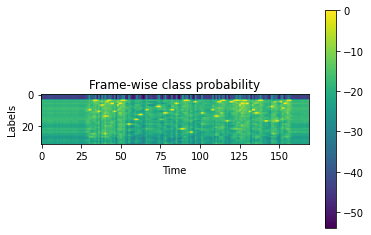

In [7]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

### Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
$t$ to denote the index in time axis and $j$ to denote the
index in label axis. $c_j$ represents the label at label index
$j$.

To generate, the probability of time step $t+1$, we look at the
trellis from time step $t$ and emission at time step $t+1$.
There are two path to reach to time step $t+1$ with label
$c_{j+1}$. The first one is the case where the label was
$c_{j+1}$ at $t$ and there was no label change from
$t$ to $t+1$. The other case is where the label was
$c_j$ at $t$ and it transitioned to the next label
$c_{j+1}$ at $t+1$.

The follwoing diagram illustrates this transition.

![](https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png)


Since we are looking for the most likely transitions, we take the more
likely path for the value of $k_{(t+1, j+1)}$, that is

$ k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1,
repeat) ) $

where $k$ represents is trellis matrix, and $p(t, c_j)$
represents the probability of label $c_j$ at time step $t$.
$repeat$ represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the `Sequence Modeling with CTC
[distill.pub] <https://distill.pub/2017/ctc/>`__)

In [9]:
transcript = 'I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT'
dictionary  = {c: i for i, c in enumerate(labels)}

In [10]:
tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

[('I', 10), ('|', 4), ('H', 11), ('A', 7), ('D', 14), ('|', 4), ('T', 6), ('H', 11), ('A', 7), ('T', 6), ('|', 4), ('C', 19), ('U', 16), ('R', 13), ('I', 10), ('O', 8), ('S', 12), ('I', 10), ('T', 6), ('Y', 22), ('|', 4), ('B', 24), ('E', 5), ('S', 12), ('I', 10), ('D', 14), ('E', 5), ('|', 4), ('M', 17), ('E', 5), ('|', 4), ('A', 7), ('T', 6), ('|', 4), ('T', 6), ('H', 11), ('I', 10), ('S', 12), ('|', 4), ('M', 17), ('O', 8), ('M', 17), ('E', 5), ('N', 9), ('T', 6)]


In [11]:
def get_trellis(emission, tokens, blank_id=0):
  num_frame = emission.size(0)
  num_tokens = len(tokens)

  # Trellis has extra diemsions for both time axis and tokens.
  # The extra dim for tokens represents <SoS> (start-of-sentence)
  # The extra dim for time axis is for simplification of the code.
  trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
  trellis[:, 0] = 0
  for t in range(num_frame):
    trellis[t+1, 1:] = torch.maximum(
        # Score for staying at the same token
        trellis[t, 1:] + emission[t, blank_id],
        # Score for changing to the next token
        trellis[t, :-1] + emission[t, tokens],
    )
  return trellis

trellis = get_trellis(emission, tokens)

In [12]:
trellis

tensor([[   0.0000,      -inf,      -inf,  ...,      -inf,      -inf,
              -inf],
        [   0.0000,  -17.8111,      -inf,  ...,      -inf,      -inf,
              -inf],
        [   0.0000,  -17.7451,  -35.0032,  ...,      -inf,      -inf,
              -inf],
        ...,
        [   0.0000,  -11.7762,  -11.2769,  ..., -158.5718, -146.9110,
         -138.3506],
        [   0.0000,  -11.7762,  -11.2769,  ..., -158.5718, -146.9110,
         -138.3506],
        [   0.0000,  -11.7762,  -11.2769,  ..., -158.5718, -146.9110,
         -138.3506]])

### Visualization.

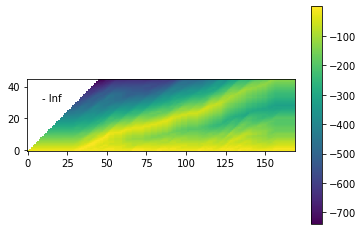

In [13]:
plt.imshow(trellis[1:, 1:].T, origin='lower')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

>In the above visualization, we can see that there is a trace of high probability crossing the matrix diagonally.

### Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.


In [14]:
@dataclass
class Point:
  token_index: int
  time_index: int
  score: float

In [16]:
def backtrack(trellis, emission, tokens, blank_id=0):
  # Note:
  # j and t are indices for trellis, which has extra dimensions
  # for time and tokens at the beginning.
  # When refering to time frame index `T` in trellis,
  # the corresponding index in emission is `T-1`.
  # Similarly, when refering to token index `J` in trellis,
  # the corresponding index in transcript is `J-1`.
  j = trellis.size(1) - 1
  t_start = torch.argmax(trellis[:, j]).item()

  path = []
  for t in range(t_start, 0, -1):
    # 1. Figure out if the current position was stay or change
    # Note (again):
    # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
    # Score for token staying the same from time frame J-1 to T.
    stayed = trellis[t-1, j] + emission[t-1, blank_id]
    # Score for token changing from C-1 at T-1 to J at T.
    changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

    # 2. Store the path with frame-wise probability.
    prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
    # Return token index and time index in non-trellis coordinate.
    path.append(Point(j-1, t-1, prob))

    # 3. Update the token
    if changed > stayed:
      j -= 1
      if j == 0:
        break
  else:
    raise ValueError('Failed to align')
  return path[::-1]

path = backtrack(trellis, emission, tokens)
print(path)

[Point(token_index=0, time_index=30, score=0.9999842643737793), Point(token_index=0, time_index=31, score=0.9847016334533691), Point(token_index=0, time_index=32, score=0.9999707937240601), Point(token_index=0, time_index=33, score=0.15400736033916473), Point(token_index=1, time_index=34, score=0.9999173879623413), Point(token_index=1, time_index=35, score=0.6080494523048401), Point(token_index=2, time_index=36, score=0.9997720122337341), Point(token_index=2, time_index=37, score=0.9997127652168274), Point(token_index=3, time_index=38, score=0.9999357461929321), Point(token_index=3, time_index=39, score=0.9861611127853394), Point(token_index=4, time_index=40, score=0.9238568544387817), Point(token_index=4, time_index=41, score=0.9257279634475708), Point(token_index=4, time_index=42, score=0.01566161774098873), Point(token_index=5, time_index=43, score=0.9998378753662109), Point(token_index=6, time_index=44, score=0.9988442659378052), Point(token_index=6, time_index=45, score=0.10147518

### Visualization

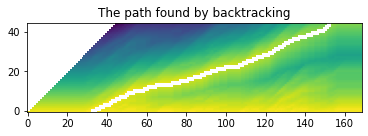

In [17]:
def plot_trellis_with_path(trellis, path):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, p in enumerate(path):
    trellis_with_path[p.time_index, p.token_index] = float('nan')
  plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

Looking good. Now this path contains repetations for the same labels, so let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average probability for the merged segments.




In [18]:
# Merge the labels
@dataclass
class Segment:
  label: str
  start: int
  end: int
  score: float

  def __repr__(self):
    return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

  @property
  def length(self):
    return self.end - self.start

def merge_repeats(path):
  i1, i2 = 0, 0
  segments = []
  while i1 < len(path):
    while i2 < len(path) and path[i1].token_index == path[i2].token_index:
      i2 += 1
    score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
    segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
    i1 = i2
  return segments

segments = merge_repeats(path)
for seg in segments:
  print(seg)

I	(0.78): [   30,    34)
|	(0.80): [   34,    36)
H	(1.00): [   36,    38)
A	(0.99): [   38,    40)
D	(0.62): [   40,    43)
|	(1.00): [   43,    44)
T	(0.55): [   44,    46)
H	(1.00): [   46,    48)
A	(0.37): [   48,    51)
T	(0.00): [   51,    52)
|	(1.00): [   52,    55)
C	(0.97): [   55,    60)
U	(1.00): [   60,    62)
R	(0.75): [   62,    66)
I	(0.88): [   66,    74)
O	(0.99): [   74,    78)
S	(1.00): [   78,    82)
I	(0.89): [   82,    85)
T	(0.78): [   85,    89)
Y	(0.70): [   89,    91)
|	(0.66): [   91,    94)
B	(1.00): [   94,    97)
E	(1.00): [   97,   101)
S	(1.00): [  101,   108)
I	(1.00): [  108,   110)
D	(0.93): [  110,   112)
E	(0.66): [  112,   115)
|	(1.00): [  115,   117)
M	(0.67): [  117,   120)
E	(0.67): [  120,   123)
|	(0.50): [  123,   125)
A	(0.98): [  125,   126)
T	(0.50): [  126,   128)
|	(0.51): [  128,   130)
T	(1.00): [  130,   131)
H	(1.00): [  131,   133)
I	(0.75): [  133,   135)
S	(0.36): [  135,   138)
|	(0.50): [  138,   142)
M	(1.00): [  142,   145)


### Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


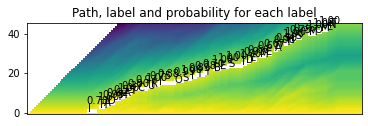

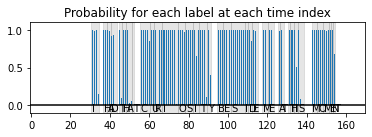

In [19]:
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  plt.figure()
  plt.title("Path, label and probability for each label")
  ax1 = plt.axes()
  ax1.imshow(trellis_with_path.T, origin='lower')
  ax1.set_xticks([])

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start + .7, i + 0.3))
      ax1.annotate(f'{seg.score:.2f}', (seg.start - .3, i + 4.3))

  plt.figure()
  plt.title("Probability for each label at each time index")
  ax2 = plt.axes()
  xs, hs = [], []
  for p in path:
    label = transcript[p.token_index]
    if label != '|':
      xs.append(p.time_index + 1)
      hs.append(p.score)

  for seg in segments:
    if seg.label != '|':
      ax2.axvspan(seg.start+.4, seg.end+.4, color='gray', alpha=0.2)
      ax2.annotate(seg.label, (seg.start + .8, -0.07))

  ax2.bar(xs, hs, width=0.5)
  ax2.axhline(0, color='black')
  ax2.set_position(ax1.get_position())
  ax2.set_xlim(ax1.get_xlim())
  ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis, segments, transcript)
plt.show()

Looks good. Now let’s merge the words. The Wav2Vec2 model uses ``'|'`` as the word boundary, so we merge the segments before each occurance of ``'|'``.

In [20]:
# Merge words
def merge_words(segments, separator='|'):
  words = []
  i1, i2 = 0, 0
  while i1 < len(segments):
    if i2 >= len(segments) or segments[i2].label == separator:
      if i1 != i2:
        segs = segments[i1:i2]
        word = ''.join([seg.label for seg in segs])
        score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
        words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
      i1 = i2 + 1
      i2 = i1
    else:
      i2 += 1
  return words

word_segments = merge_words(segments)
for word in word_segments:
  print(word)

I	(0.78): [   30,    34)
HAD	(0.84): [   36,    43)
THAT	(0.52): [   44,    52)
CURIOSITY	(0.89): [   55,    91)
BESIDE	(0.94): [   94,   115)
ME	(0.67): [  117,   123)
AT	(0.66): [  125,   128)
THIS	(0.70): [  130,   138)
MOMENT	(0.97): [  142,   154)


### Visualization

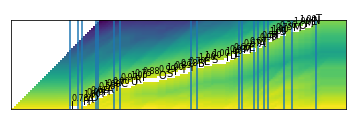

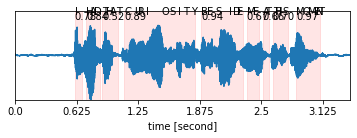

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT


I: 0.604 - 0.684


HAD: 0.724 - 0.865


THAT: 0.885 - 1.046


CURIOSITY: 1.107 - 1.831


BESIDE: 1.891 - 2.314


ME: 2.354 - 2.474


AT: 2.515 - 2.575


THIS: 2.615 - 2.776


MOMENT: 2.857 - 3.098


In [21]:
trellis_with_path = trellis.clone()
for i, seg in enumerate(segments):
  if seg.label != '|':
    trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')
ax1 = plt.gca()
ax1.set_yticks([])
ax1.set_xticks([])


for word in word_segments:
  plt.axvline(word.start - 0.5)
  plt.axvline(word.end - 0.5)

for i, seg in enumerate(segments):
  if seg.label != '|':
    plt.annotate(seg.label, (seg.start, i + 0.3))
    plt.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

plt.show()

# The original waveform
ratio = waveform.size(1) / (trellis.size(0) - 1)
plt.plot(waveform[0])
for word in word_segments:
  x0 = ratio * word.start
  x1 = ratio * word.end
  plt.axvspan(x0, x1, alpha=0.1, color='red')
  plt.annotate(f'{word.score:.2f}', (x0, 0.8))

for seg in segments:
  if seg.label != '|':
    plt.annotate(seg.label, (seg.start * ratio, 0.9))

ax2 = plt.gca()
xticks = ax2.get_xticks()
plt.xticks(xticks, xticks / bundle.sample_rate)
plt.xlabel('time [second]')
ax2.set_position(ax1.get_position())
ax2.set_yticks([])
ax2.set_ylim(-1.0, 1.0)
ax2.set_xlim(0, waveform.size(-1))
plt.show()

# Generate the audio for each segment
print(transcript)
IPython.display.display(IPython.display.Audio(SPEECH_FILE))
for i, word in enumerate(word_segments):
  x0 = int(ratio * word.start)
  x1 = int(ratio * word.end)
  filename = f"{i}_{word.label}.wav"
  torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
  print(f"{word.label}: {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f}")
  IPython.display.display(IPython.display.Audio(filename))